In [71]:
from google.colab import drive
import pandas as pd



In [72]:
drive.mount('/content/drive')
file_path="/content/drive/MyDrive/Churn_Modelling.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print(df.head())
print(df.info())
#print(df.describe())
print("\nMissing Values:", df.isnull().sum())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape: (10002, 14)
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   
3          4    15701354      Boni          699    France  Female  39.0   
4          5    15737888  Mitchell          850     Spain  Female  43.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1        1.0             1.0   
1       1   83807.86              1        0.0             1.0   
2       8  159660.80              3        1.0             0.0   
3       1       0.00              2        0.0             0.0   
4       2  125510.82              1        NaN             1.0   

   E

**Data Cleaning**

In [73]:
#Drop identifiers
df = df.drop(['RowNumber', "Surname", "CustomerId"], axis=1)

In [74]:
#Handle missing values
df.fillna({
    "Geography": df["Geography"].mode()[0],
    "Age": df["Age"].median(),
    "HasCrCard": df["HasCrCard"].mode()[0],
    "IsActiveMember": df["IsActiveMember"].mode()[0]
}, inplace=True)

In [75]:
#Double check
print(df.isnull().sum())

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [76]:
#Churn Distribution
print(df["Exited"].value_counts(normalize = True))

Exited
0    0.796241
1    0.203759
Name: proportion, dtype: float64


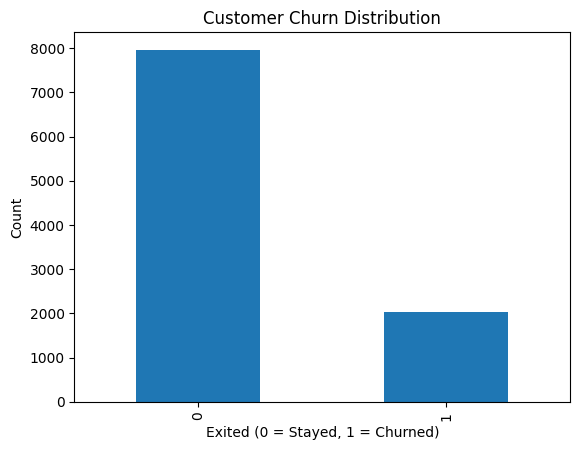

In [77]:
import matplotlib.pyplot as plt
df["Exited"].value_counts().plot(kind = "bar")
plt.title("Customer Churn Distribution")
plt.xlabel("Exited (0 = Stayed, 1 = Churned)")
plt.ylabel("Count")
plt.show()

Exploratory Data Analysis

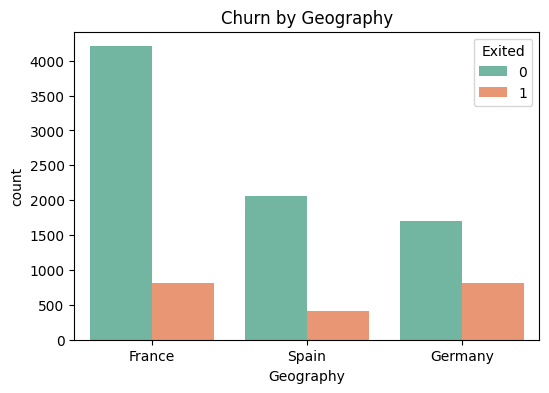

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
sns.countplot(data = df, x = "Geography", hue = "Exited", palette = "Set2")
plt.title("Churn by Geography")
plt.show()

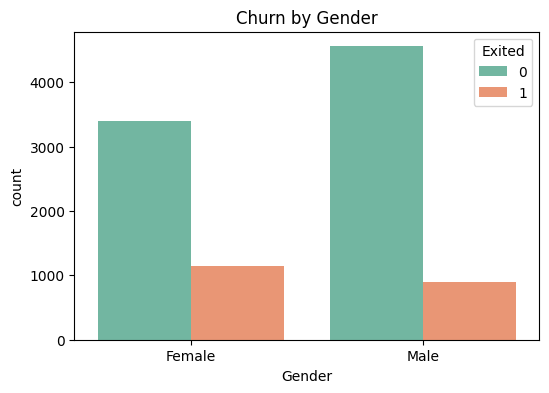

In [79]:
plt.figure(figsize = (6,4))
sns.countplot(data=df, x = "Gender", hue = "Exited", palette = "Set2")
plt.title("Churn by Gender")
plt.show()

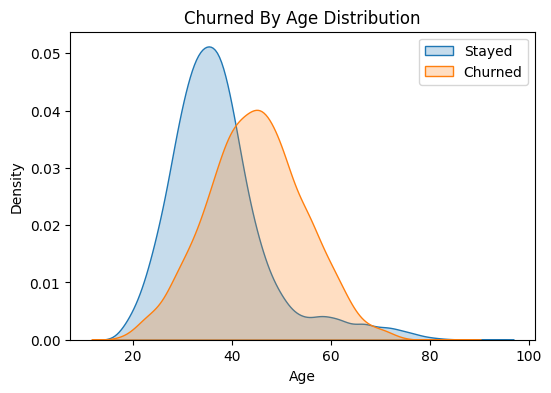

In [80]:
plt.figure(figsize = (6,4))
sns.kdeplot(df[df["Exited"]==0 ] ['Age'], fill = True , label = "Stayed")
sns.kdeplot(df[df["Exited"]==1] ["Age"], fill = True, label = "Churned")
plt.title("Churned By Age Distribution")
plt.xlabel("Age")
plt.legend()
plt.show()

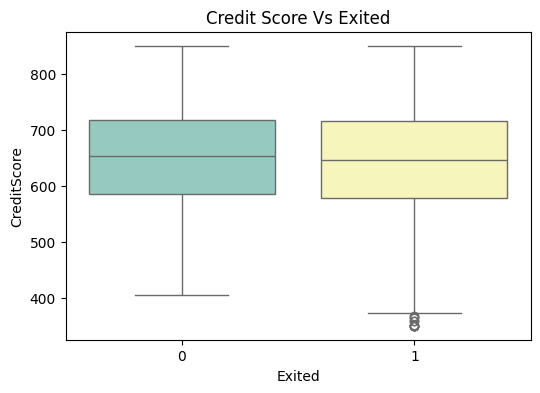

In [81]:
plt.figure(figsize = (6,4))
sns.boxplot(data = df, x = "Exited", y = "CreditScore", hue = "Exited", legend = False, palette = "Set3")
plt.title("Credit Score Vs Exited")
plt.show()

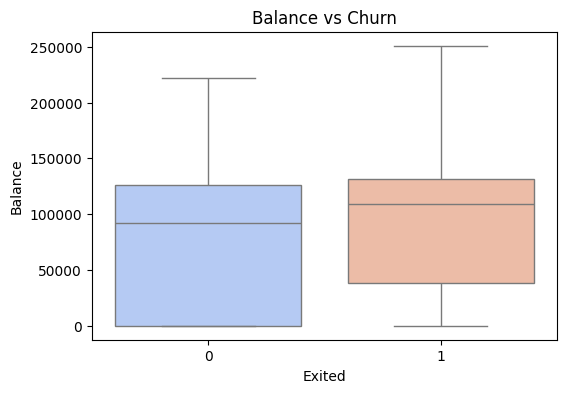

In [82]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Exited", y="Balance", hue = "Exited", legend = False, palette="coolwarm")
plt.title("Balance vs Churn")
plt.show()

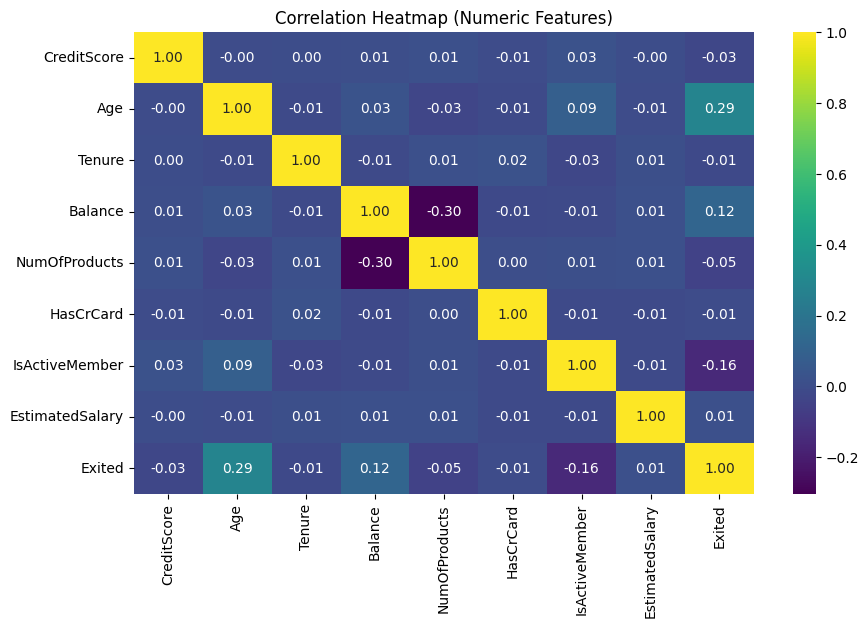

In [83]:
plt.figure(figsize=(10,6))
numeric_df = df.select_dtypes(include=['number'])   # keep only numeric columns
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [84]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)

df_encoded.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42.0,2,0.00,1,1.0,1.0,101348.88,1,False,False,False
1,608,41.0,1,83807.86,1,0.0,1.0,112542.58,0,False,True,False
2,502,42.0,8,159660.80,3,1.0,0.0,113931.57,1,False,False,False
3,699,39.0,1,0.00,2,0.0,0.0,93826.63,0,False,False,False
4,850,43.0,2,125510.82,1,1.0,1.0,79084.10,0,False,True,False


In [85]:
# X = all independent variables (features)
# y = dependent variable (churn)
X = df_encoded.drop("Exited", axis=1)
y = df_encoded["Exited"]


**Split Data into Train & Test**

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Logistic Regression (baseline model)**

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Initialize model
log_reg = LogisticRegression(max_iter=1000)

# Train
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.808095952023988
Confusion Matrix:
 [[1539   54]
 [ 330   78]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.29       408

    accuracy                           0.81      2001
   macro avg       0.71      0.58      0.59      2001
weighted avg       0.78      0.81      0.77      2001



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create Random Forest model with class balancing
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Accuracy: 0.8610694652673663
Confusion Matrix:
 [[1535   58]
 [ 220  188]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.92      1593
           1       0.76      0.46      0.57       408

    accuracy                           0.86      2001
   macro avg       0.82      0.71      0.75      2001
weighted avg       0.85      0.86      0.85      2001



**SMOTE (Synthetic Minority Oversampling Technique) to balance the churn (1) vs non-churn (0) classes.**

In [90]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make a copy of the dataframe
df_encoded = df.copy()

# Encode categorical columns
for col in df_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Separate features and target
X = df_encoded.drop("Exited", axis=1)
y = df_encoded["Exited"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", y_train_res.value_counts())

# Train Random Forest
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_res, y_train_res)

# Predictions
y_pred_smote = rf_smote.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))


Before SMOTE:
 Exited
0    6371
1    1630
Name: count, dtype: int64
After SMOTE:
 Exited
0    6371
1    6371
Name: count, dtype: int64
Accuracy: 0.8470764617691154
Confusion Matrix:
 [[1455  138]
 [ 168  240]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.63      0.59      0.61       408

    accuracy                           0.85      2001
   macro avg       0.77      0.75      0.76      2001
weighted avg       0.84      0.85      0.84      2001



**Train a Random Forest Model**

In [94]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest on the resampled data (after SMOTE)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_res, y_train_res)

# Evaluate on test data
y_pred_rf = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8470764617691154
Confusion Matrix:
 [[1455  138]
 [ 168  240]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1593
           1       0.63      0.59      0.61       408

    accuracy                           0.85      2001
   macro avg       0.77      0.75      0.76      2001
weighted avg       0.84      0.85      0.84      2001



**Get Feature Importances**

           Feature  Importance
3              Age    0.242937
8   IsActiveMember    0.172506
9  EstimatedSalary    0.096864
5          Balance    0.095063
6    NumOfProducts    0.091959
0      CreditScore    0.086508
7        HasCrCard    0.063580
2           Gender    0.056972
4           Tenure    0.053440
1        Geography    0.040171


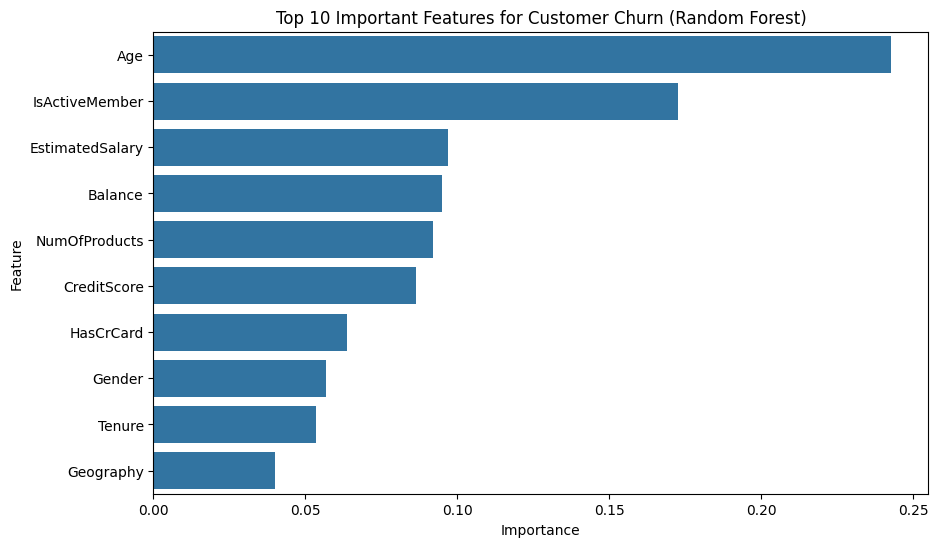

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
features = X.columns

# Put into DataFrame
feat_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Print top 10 features
print(feat_importances.head(10))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importances.head(10))
plt.title("Top 10 Important Features for Customer Churn (Random Forest)")
plt.show()


In [97]:
# Retrain Logistic Regression on the resampled data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_res, y_train_res)

# Re-run evaluation
log_reg_results = evaluate_model(log_reg, X_test, y_test)
rf_results = evaluate_model(rf_model, X_test, y_test)

# Compare results in a DataFrame
results_df = pd.DataFrame([log_reg_results, rf_results],
                          index=["Logistic Regression", "Random Forest"])

print(results_df)


                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.710145   0.379552  0.664216  0.483066
Random Forest        0.847076   0.634921  0.588235  0.610687


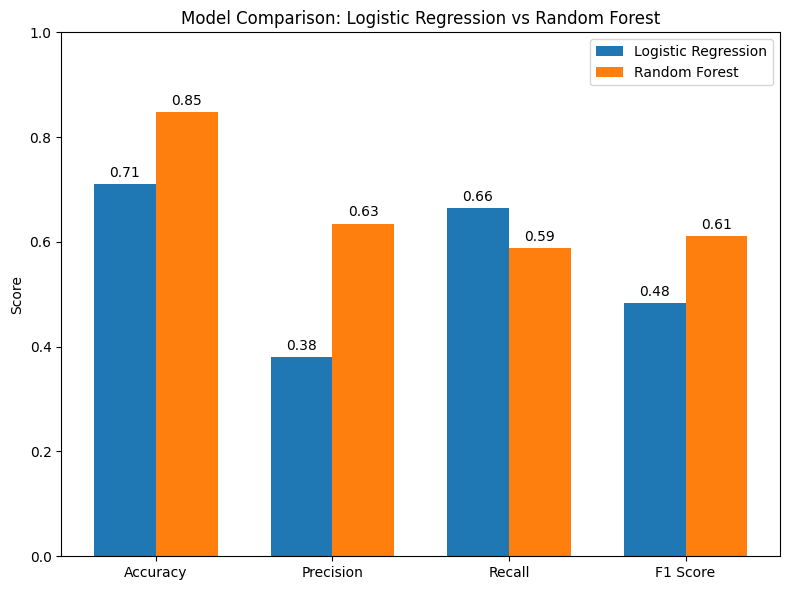

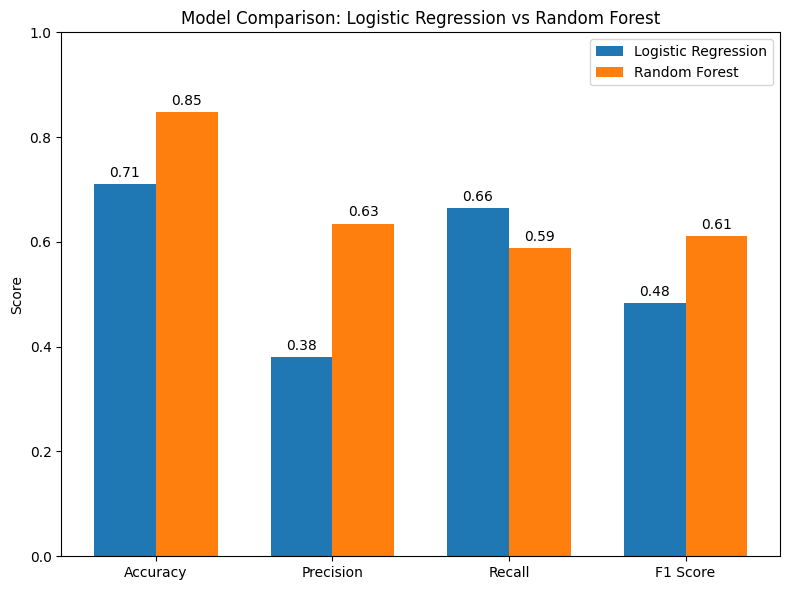

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
log_reg_scores = [0.710145, 0.379552, 0.664216, 0.483066]
rf_scores = [0.847076, 0.634921, 0.588235, 0.610687]

x = np.arange(len(metrics))  # positions
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, log_reg_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')

# Add text labels above bars
ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

# Chart formatting
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Logistic Regression vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Metrics from your results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
log_reg_scores = [0.710145, 0.379552, 0.664216, 0.483066]
rf_scores = [0.847076, 0.634921, 0.588235, 0.610687]

x = np.arange(len(metrics))  # positions
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, log_reg_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')

# Add text labels above bars
ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

# Chart formatting
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Logistic Regression vs Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, 1)
plt.tight_layout()
plt.show()
